In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE =224
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Fish Dataset/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4599 files belonging to 7 classes.


In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Fish Dataset/train"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
class_names = dataset.class_names
class_names

['Centropristis striata',
 'Dawkinsia singhala',
 'Devario aequipinnatus',
 'Katsuwonus pelamis',
 'Lactarius lactarius',
 'Mullus surmuletus',
 'Scomber scombrus']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[6 5 0 0 1 3 2 6 0 0 5 6 5 6 6 6 0 1 4 4 1 0 1 4 6 6 1 3 5 5 4 4]


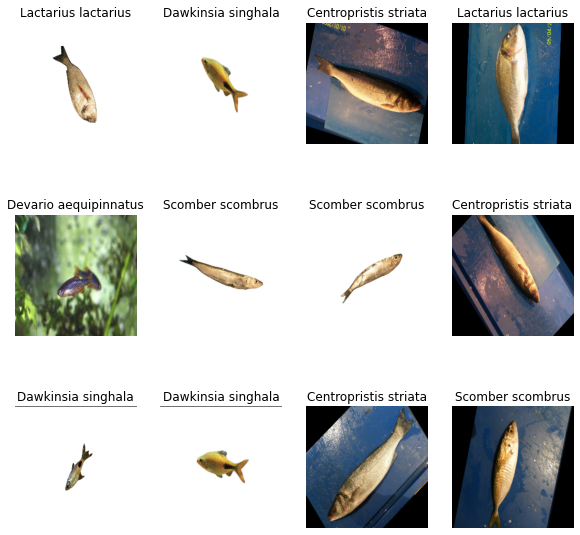

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

144

In [ ]:
train_size = 0.8
len(dataset)*train_size

115.2

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

90

In [ ]:

val_size=0.1
len(dataset)*val_size

14.4

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

84

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:

len(train_ds)

115

In [ ]:
len(val_ds)

14

In [ ]:
len(test_ds)

15

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE_new = [224, 224]

In [ ]:
# Import the inception v3 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE_new + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Fish Dataset/train/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:

r = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
115/115 [==============================] - 527s 4s/step - loss: 83.8755 - accuracy: 0.5494 - val_loss: 24.8088 - val_accuracy: 0.7054
Epoch 2/20
115/115 [==============================] - 419s 4s/step - loss: 18.5861 - accuracy: 0.7744 - val_loss: 19.1180 - val_accuracy: 0.8214
Epoch 3/20
115/115 [==============================] - 419s 4s/step - loss: 17.9939 - accuracy: 0.8060 - val_loss: 13.0460 - val_accuracy: 0.8594
Epoch 4/20
115/115 [==============================] - 416s 4s/step - loss: 10.7849 - accuracy: 0.8774 - val_loss: 20.4972 - val_accuracy: 0.7589
Epoch 5/20
115/115 [==============================] - 416s 4s/step - loss: 13.1859 - accuracy: 0.8657 - val_loss: 24.4356 - val_accuracy: 0.7589
Epoch 6/20
115/115 [==============================] - 415s 4s/step - loss: 11.4718 - accuracy: 0.8864 - val_loss: 10.5899 - val_accuracy: 0.8683
Epoch 7/20
115/115 [==============================] - 416s 4s/step - loss: 4.9904 - accuracy: 0.9297 - val_loss: 15.8803 - val_acc

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("inception_V3_test66.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
import os

In [ ]:
labels = [folder for folder in os.listdir('/content/drive/MyDrive/Fish Dataset/train') if not folder.startswith('.')]

with open('labels66.txt', 'w') as f:
    for label in labels:
      f.write(label)
      f.write('\n')


In [ ]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 109s 4s/step - loss: 16.5251 - accuracy: 0.9271


In [ ]:
scores

[16.52505111694336, 0.9270833134651184]

In [ ]:
r.params

{'verbose': 1, 'epochs': 20, 'steps': 115}

In [ ]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
len(r.history['loss'])

20

In [ ]:
r.history['loss'][:5] # show loss for first 5 epochs

[83.87554168701172,
 18.586076736450195,
 17.993894577026367,
 10.784859657287598,
 13.185907363891602]

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

ValueError: ignored

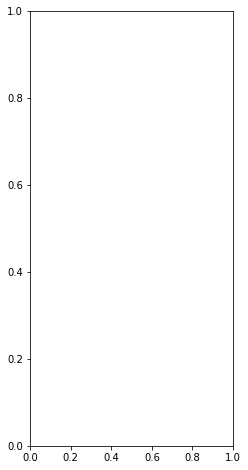

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Lactarius lactarius
predicted label: Lactarius lactarius


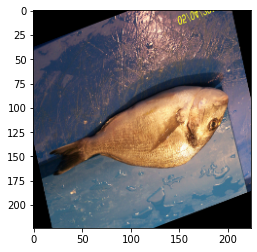

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

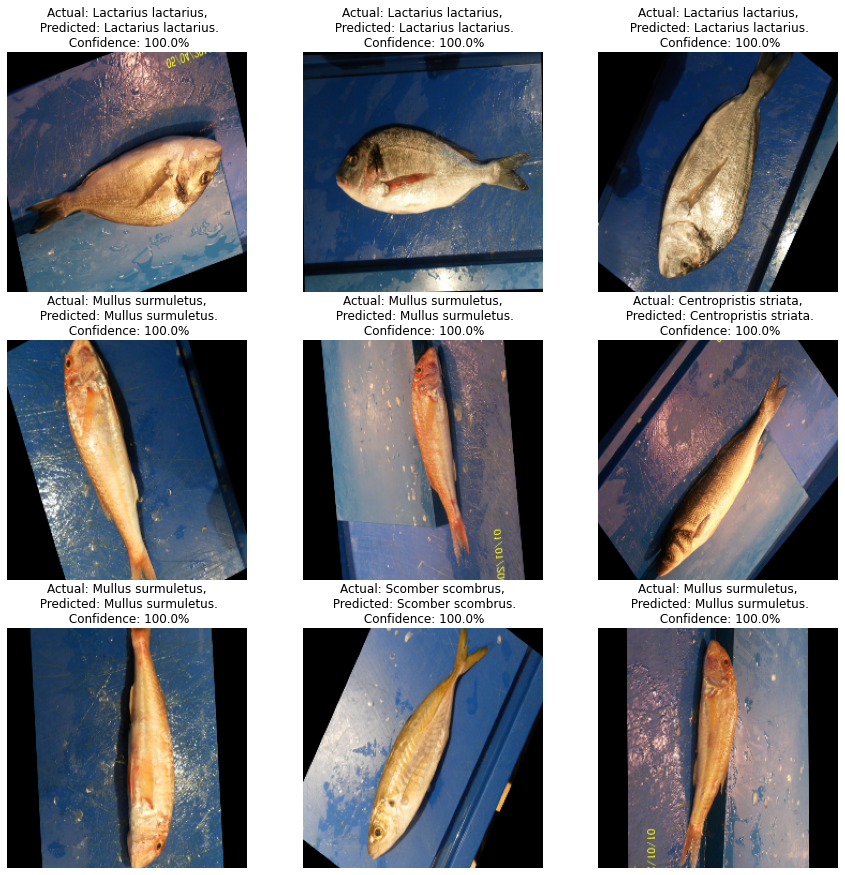

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./models/1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
file = open( 'testcnn12.tflite' , 'wb' ) 
file.write( tflite_model )

201960